In [1]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.formula.api import glm
from statsmodels.genmod.families import Poisson
import numpy as np

In [2]:
df = pq.read_table("Data/cases.parquet").to_pandas()

In [3]:
df

,ID,Updated,Confirmed,Confirmed_Change,ISO3
0,7159711,2020-01-25,1,0,CAN
1,7159713,2020-01-26,1,0,CAN
2,7159715,2020-01-27,2,1,CAN
3,7159717,2020-01-28,3,1,CAN
4,339668,2020-01-29,3,0,CAN
...,...,...,...,...,...
4205,123955635,2021-03-21,4296583,5312,GBR
4206,123955636,2021-03-22,4301925,5342,GBR
4207,124072966,2021-03-23,4304614,2689,GBR
4208,124091106,2021-03-24,4307304,2690,GBR


In [4]:
swe_data = df[df['ISO3'] == 'SWE']
swe_data.reset_index().drop(columns= 'index')

,ID,Updated,Confirmed,Confirmed_Change,ISO3
0,5468899,2020-01-31,1,0,SWE
1,340207,2020-02-01,1,0,SWE
2,340208,2020-02-02,1,0,SWE
3,340209,2020-02-03,1,0,SWE
4,7161134,2020-02-04,1,0,SWE
...,...,...,...,...,...
415,123848432,2021-03-21,751303,3516,SWE
416,123994182,2021-03-22,754819,3516,SWE
417,124073227,2021-03-23,758335,3516,SWE
418,124091153,2021-03-24,765984,7649,SWE


In [5]:
def kpss_test(series, **kw):
    statistic, p_value, lags, crit = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:', crit)

kpss_test(swe_data['Confirmed_Change'])


KPSS Statistic: 2.3666035256147016
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/bt/86lz0s690976w8zzkrb1pcc00000gn/T/ipykernel_58981/2693899429.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, crit = kpss(series, **kw)


In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:', result[4])

adf_test(swe_data['Confirmed_Change'])


ADF Statistic: -1.8960403091897706
p-value: 0.3339261610543488
Critical Values: {'1%': -3.4467631030732506, '5%': -2.868774682311516, '10%': -2.570623877774392}


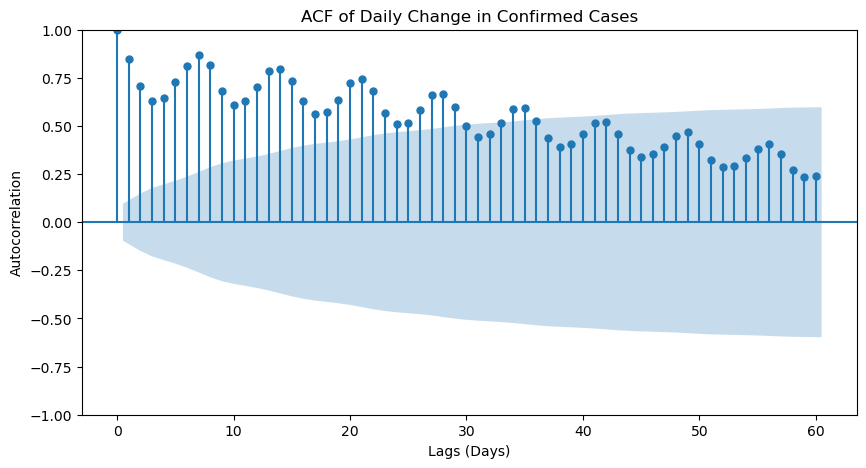

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(swe_data['Confirmed_Change'].dropna(), ax=ax, lags=60, title='ACF of Daily Change in Confirmed Cases')
plt.xlabel('Lags (Days)')
plt.ylabel('Autocorrelation')
plt.show()

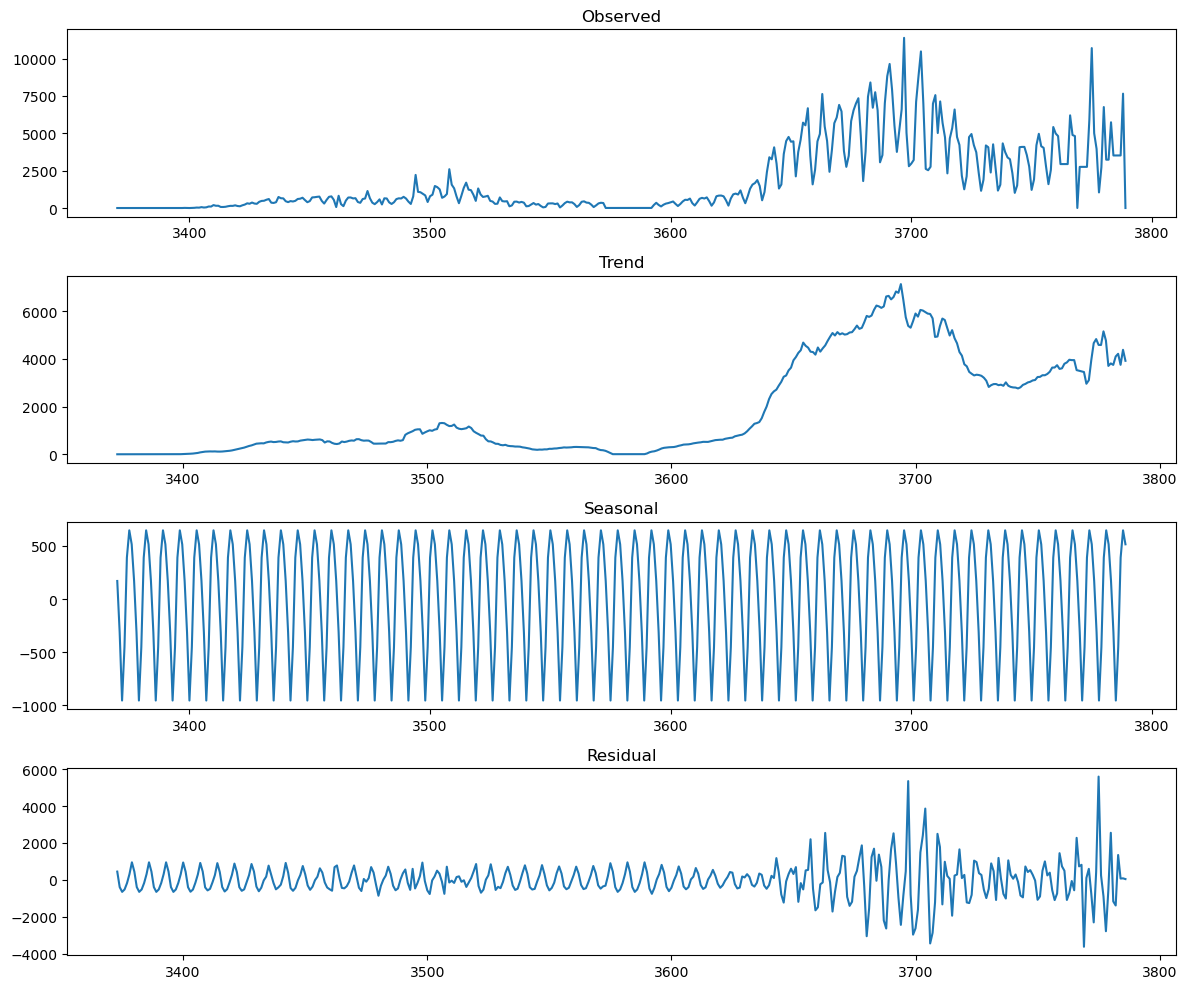

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(swe_data['Confirmed_Change'], model='additive', period=7)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()


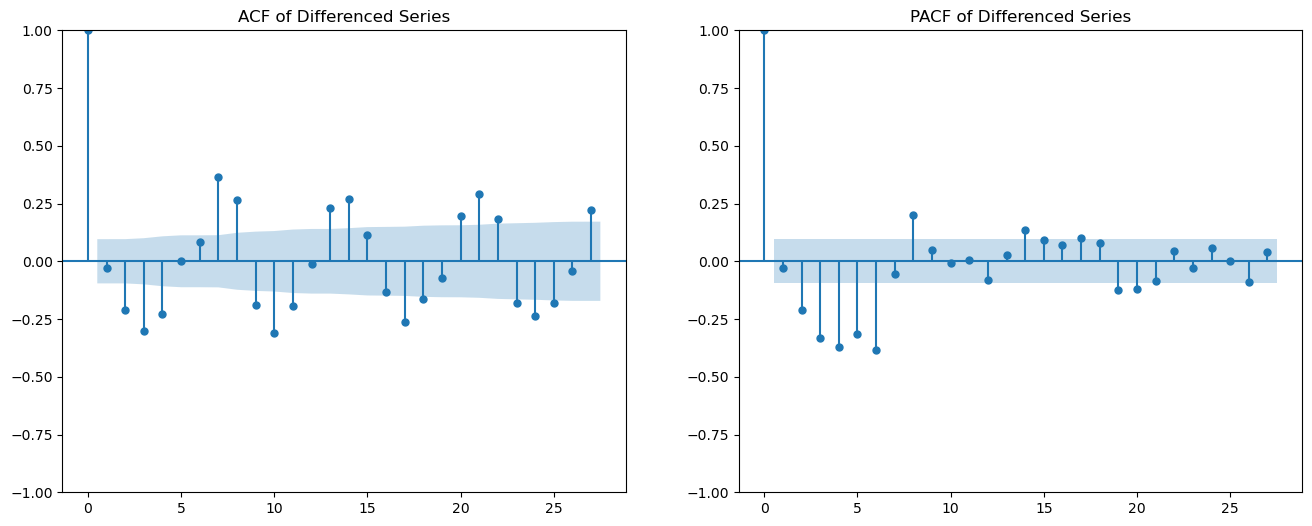

In [9]:
sweden_diff = swe_data['Confirmed_Change'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(sweden_diff, ax=ax1, title='ACF of Differenced Series')
plot_pacf(sweden_diff, ax=ax2, title='PACF of Differenced Series')
plt.show()

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(swe_data['Confirmed_Change'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_model = model.fit(disp=False)

sarima_model.summary()

/Users/namannagaria/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/namannagaria/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                  Confirmed_Change   No. Observations:                  420
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3337.563
Date:                           Sat, 04 May 2024   AIC                           6685.127
Time:                                   17:36:05   BIC                           6705.122
Sample:                                        0   HQIC                          6693.043
                                           - 420                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2110      0.031      6.831      0.000       0.150       0.272
ma.L1         -0.8762      0.024    -35.850      0.000      -0.924      -0.828
ar.S.L7        0.2530      0.034      7.364      0.000       0.186       0.320
ma.S.L7       -0.8757      0.022    -38.996      0.000      -0.920      -0.832
sigma2      9.046e+05   2.85e+04     31.725      0.000    8.49e+05     9.6e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):              2301.55
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):              38.76   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
forecast = sarima_model.forecast(steps=30)

/Users/namannagaria/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/namannagaria/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


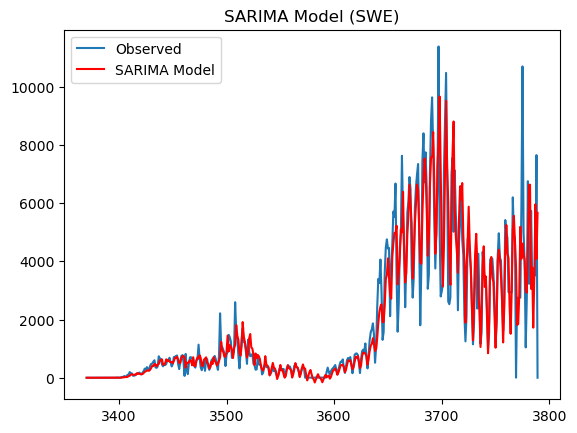

In [12]:
plt.figure()
plt.plot(swe_data['Confirmed_Change'])
plt.plot(sarima_model.fittedvalues, color='red')
plt.title('SARIMA Model (SWE)')
plt.legend(['Observed', 'SARIMA Model'])

In [13]:
swe_data = swe_data.reset_index().drop(columns = 'index')

In [14]:
swe_data['Confirmed_Change'][419] = 7704

/var/folders/bt/86lz0s690976w8zzkrb1pcc00000gn/T/ipykernel_58981/2470667453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swe_data['Confirmed_Change'][419] = 7704


In [15]:
swe_data

,ID,Updated,Confirmed,Confirmed_Change,ISO3
0,5468899,2020-01-31,1,0,SWE
1,340207,2020-02-01,1,0,SWE
2,340208,2020-02-02,1,0,SWE
3,340209,2020-02-03,1,0,SWE
4,7161134,2020-02-04,1,0,SWE
...,...,...,...,...,...
415,123848432,2021-03-21,751303,3516,SWE
416,123994182,2021-03-22,754819,3516,SWE
417,124073227,2021-03-23,758335,3516,SWE
418,124091153,2021-03-24,765984,7649,SWE


In [16]:
forecast = sarima_model.forecast(steps=60)

forecast

/Users/namannagaria/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/namannagaria/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


420    3224.514362
421    2723.102733
422    2101.415309
423    2740.822753
424    4109.666056
425    5685.548987
426    2850.628533
427    3333.875369
428    2650.124026
429    1740.666163
430    2514.354667
431    4223.704690
432    5151.432707
433    3534.178944
434    3323.851725
435    2593.958337
436    1611.694344
437    2419.354408
438    4214.849897
439    4978.599696
440    3669.406212
441    3283.610104
442    2542.043134
443    1541.359752
444    2357.614359
445    4174.903986
446    4897.168561
447    3665.911951
448    3235.723567
449    2491.203271
450    1485.859926
451    2304.288885
452    4127.092261
453    4838.861395
454    3627.322213
455    3185.902926
456    2440.635461
457    1434.113181
458    2253.092235
459    4077.290547
460    4786.404415
461    3579.853590
462    3135.592971
463    2390.136478
464    1383.315937
465    2202.434161
466    4026.985381
467    4735.427487
468    3530.138678
469    3085.159224
470    2339.654908
471    1332.758909
472    2151.

In [17]:
swe_cases = swe_data['Confirmed_Change']
swe_cases = list(swe_cases) + list(forecast)
swe_cases

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 8,
 3,
 0,
 5,
 13,
 30,
 25,
 59,
 33,
 46,
 101,
 98,
 196,
 151,
 152,
 71,
 69,
 83,
 119,
 145,
 143,
 180,
 134,
 117,
 182,
 230,
 314,
 286,
 366,
 300,
 281,
 415,
 475,
 486,
 554,
 601,
 357,
 340,
 389,
 738,
 655,
 645,
 455,
 394,
 464,
 437,
 480,
 604,
 623,
 688,
 532,
 389,
 462,
 709,
 721,
 747,
 765,
 475,
 297,
 542,
 749,
 778,
 547,
 64,
 819,
 259,
 123,
 495,
 702,
 705,
 642,
 656,
 401,
 348,
 602,
 637,
 1137,
 651,
 358,
 258,
 394,
 578,
 238,
 649,
 637,
 379,
 271,
 384,
 597,
 648,
 639,
 749,
 637,
 429,
 272,
 775,
 2214,
 1080,
 1056,
 948,
 843,
 403,
 791,
 890,
 1474,
 1396,
 1247,
 683,
 769,
 940,
 2596,
 1560,
 1318,
 774,
 322,
 813,
 1344,
 1698,
 1229,
 1195,
 894,
 477,
 1309,
 908,
 740,
 771,
 817,
 476,
 433,
 275,
 289,
 709,
 462,
 440,
 455,
 114,
 173,
 421,
 429,
 364,
 409,
 357,
 115,
 133,
 230,
 333,
 227,
 267,
 139

In [18]:
df = pd.DataFrame(swe_cases, columns=['Cases'])

df['Date'] = pd.date_range(start='2020-01-31', periods=len(swe_cases), freq='D')

df

,Cases,Date
0,0.000000,2020-01-31
1,0.000000,2020-02-01
2,0.000000,2020-02-02
3,0.000000,2020-02-03
4,0.000000,2020-02-04
...,...,...
475,3479.855472,2021-05-20
476,3034.694158,2021-05-21
477,2289.177744,2021-05-22
478,1282.262654,2021-05-23


In [19]:
df['Rolling_Adjusted'] = df['Cases'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

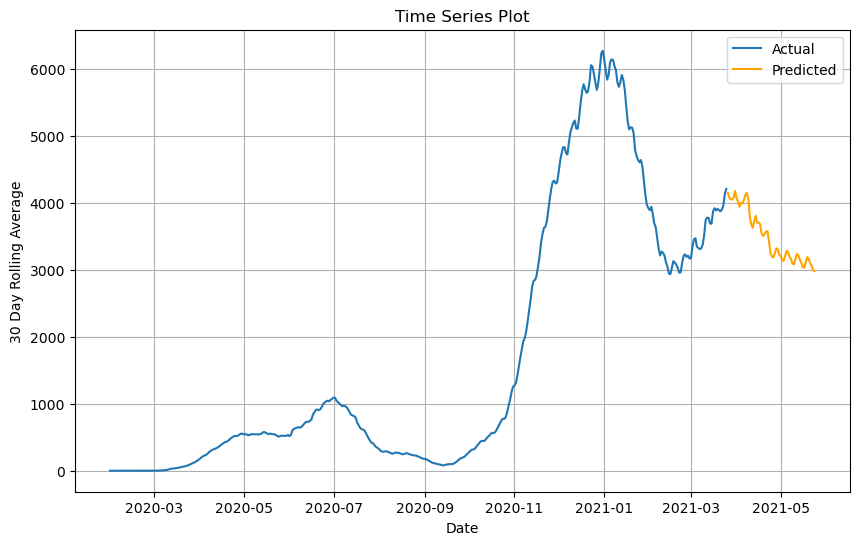

In [20]:
last_n = 60
cutoff_index = len(df) - last_n

plt.figure(figsize=(10, 6))
plt.plot(df['Date'][:cutoff_index], df['Rolling_Adjusted'][:cutoff_index], label='Actual')

plt.plot(df['Date'][cutoff_index:], df['Rolling_Adjusted'][cutoff_index:], color='orange', label='Predicted')

plt.xlabel('Date')
plt.ylabel('30 Day Rolling Average')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)

plt.show()